## This notebook attempts to train and validate a DCTR model paramterized by the top mass

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as K

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load Data

## Utilities

In [3]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [4]:
def preprocess_data(X):
    #for x in X: 
        #normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=4)
    return X

## Process Data

In [5]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/aandreassen/DCTRFitting/'

In [6]:
train_dataset_0 = np.load(data_dir + 'part_172_5_6j.npy')
train_dataset_1 = np.load(data_dir + 'part_varmass_6j.npy')

In [7]:
X0 = preprocess_data(train_dataset_0)

# shorten X1 to same length as X0   
# s.t. network sees an equal number 
# of examples from X0 and X1        

X1 = preprocess_data(train_dataset_1)[:len(X0)]

In [8]:
# Zip uniformally sampled top mass in part_varmass_6j
# with part_172_5_6j


for i in range(len(X1)):
    for j in range(6):
        X0[i, j, 4] = X1[i, j, 4]

# X0 already zipped with mT uniformally sampled

In [9]:
Y0 = np.zeros_like(X0[:,0,0])
Y1 = np.ones_like(X1[:,0,0])

In [10]:
X = np.concatenate((X0, X1), axis = 0)

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [11]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

In [12]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(103878, 6, 5)
(103878, 2)
(11542, 6, 5)
(11542, 2)


# Build Model

In [13]:
# network architecture parameters
Phi_sizes = (200,200, 256)
F_sizes = (200,200, 200)

dctr = PFN(input_dim=5, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)



# Train model

In [14]:
save_label = 'TOP_DCTR'

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, EarlyStopping]

In [15]:
count = 0
n_fail1 = 0
n_fail2 = 0
n_succ = 0

while True:
    count +=1
    print("Iteration: ", count)
    
    K.clear_session()
    dctr = PFN(input_dim=5, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)
    history = dctr.fit(X_train, Y_train,
                        epochs = 1,
                        batch_size = 1000,
                        validation_data = (X_val, Y_val),
                        verbose = 1, 
                        callbacks = callbacks)
    
    if history.history['val_loss'][0] > 6: # Fail case 1
        n_fail1 += 1
    elif history.history['val_loss'][0] < 0.1: # Fail case 2
        n_fail2 += 1
    else: # success
        n_succ += 1
        if count >= 1000:
            break
            
n_fail = n_fail1 + n_fail2

Iteration:  1


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 103878 samples, validate on 11542 samples
Epoch 1/1





103878/103878 [==============================] - 3s 29us/step - loss: 8.0822 - acc: 0.4986 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss improved from inf to 7.86354, saving model to ./saved_models/TOP_DCTR.h5
Iteration:  2
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  3
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  4
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/10387

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  24
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  25
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  26
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  27
Train on 103878 samples, validate on 

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  56
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  57
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  58
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  59
Train on 103878 samples, validate on 

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  88
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  89
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  90
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  91
Train on 103878 samples, validate on 

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  120
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  121
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  122
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  123
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  152
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0379 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  153
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  154
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0485 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  155
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  184
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 27us/step - loss: 8.0847 - acc: 0.4984 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  185
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 28us/step - loss: 8.0877 - acc: 0.4980 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  186
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 28us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  187
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 31us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  216
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0385 - acc: 0.4985 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  217
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 28us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  218
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  219
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  248
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  249
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  250
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  251
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  280
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  281
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  282
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  283
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  312
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  313
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0740 - acc: 0.4990 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  314
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  315
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  344
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  345
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  346
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  347
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  376
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  377
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  378
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0836 - acc: 0.4985 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  379
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 30us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  408
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  409
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  410
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  411
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 30us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  440
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0642 - acc: 0.4986 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  441
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  442
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0363 - acc: 0.5009 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  443
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 29us/step - loss: 8.0407 - acc: 0.5011 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  472
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  473
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 30us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  474
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 29us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  475
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  504
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0395 - acc: 0.5012 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  505
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  506
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  507
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  536
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  537
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  538
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  539
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0669 - acc: 0.4990 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  568
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  569
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  570
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0673 - acc: 0.4986 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  571
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  600
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  601
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  602
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0769 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  603
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  632
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  633
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0271 - acc: 0.5011 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  634
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  635
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  664
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  665
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  666
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  667
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  696
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  697
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  698
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  699
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0869 - acc: 0.4983 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  728
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  729
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.1171 - acc: 0.4964 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  730
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 27us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  731
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  760
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0302 - acc: 0.4990 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  761
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  762
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  763
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0714 - acc: 0.4988 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  792
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0870 - acc: 0.4983 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  793
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  794
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  795
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  824
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 27us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  825
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  826
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  827
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  856
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  857
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  858
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  859
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  888
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  889
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  890
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  891
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  920
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  921
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  922
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  923
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  952
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  953
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  954
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  955
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  984
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 27us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  985
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  986
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 3s 27us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  987
Train on 103878 samples, validate

103878/103878 [==============================] - 3s 26us/step - loss: 8.0808 - acc: 0.4987 - val_loss: 7.8635 - val_acc: 0.5121

Epoch 00001: val_loss did not improve from 7.86354
Iteration:  1016
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
  1000/103878 [..............................] - ETA: 53s - loss: 8.1880 - acc: 0.4920WARNING:tensorflow:From /home/asuresh/.local/lib/python2.7/site-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



KeyboardInterrupt: 

In [17]:
n_fail = n_fail1 + n_fail2

print("Number of initializations failed: ", n_fail, "/", count)
print("Percentage of initializations failed:", (100*n_fail/count), "%")

print("Number of initializations succeeded: ", n_succ, "/", count)
print("Percentage of initializations succeeded:", (100*n_succ/count), "%")

Number of initializations failed:  1015 / 1016
Percentage of initializations failed: 99.9015748031 %
Number of initializations succeeded:  0 / 1016
Percentage of initializations succeeded: 0.0 %


Finish training

In [18]:
history = dctr.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 1000,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Train on 103878 samples, validate on 11542 samples
Epoch 1/100
103878/103878 [==============================] - 2s 22us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00001: val_loss did not improve from 7.86354
Epoch 2/100
103878/103878 [==============================] - 2s 21us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00002: val_loss did not improve from 7.86354
Epoch 3/100
103878/103878 [==============================] - 2s 21us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00003: val_loss did not improve from 7.86354
Epoch 4/100
103878/103878 [==============================] - 2s 21us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00004: val_loss did not improve from 7.86354
Epoch 5/100
103878/103878 [==============================] - 2s 21us/step - loss: 8.0373 - acc: 0.5013 - val_loss: 8.2546 - val_acc: 0.4879

Epoch 00005: val_loss did not improve fr

# Plot History

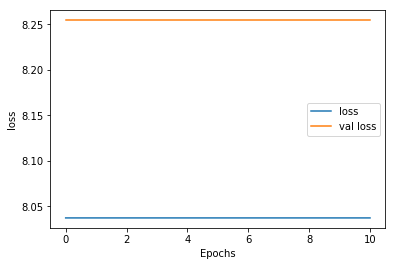

In [19]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Load Datasets

In [20]:
test_dataset_0 = np.load(data_dir+'part_172_5_6j.npy')
test_dataset_1 = np.load(data_dir+'part_175_0_6j.npy')

In [21]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [22]:
# Load test datasets
X0_test = preprocess_data(test_dataset_0)
X1_test = preprocess_data(test_dataset_1)



In [23]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

In [24]:
print(preds_0[0:20]) # Network hasn't trained 

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Get weights

In [25]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

## Analyze weights

In [26]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

0.0
inf
0.0
inf


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


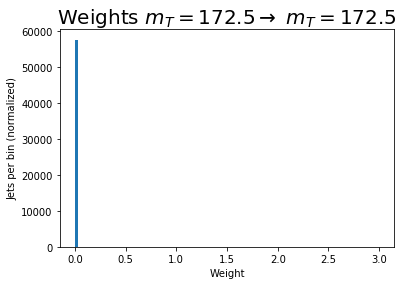

In [27]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
plt.show()

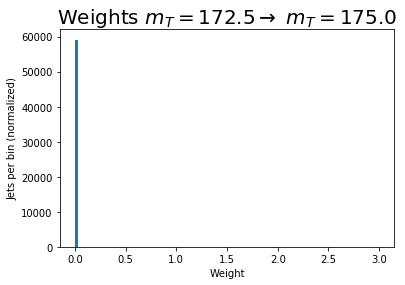

In [28]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
plt.show()